# 2.4.2 [Challenge: make your own regressino model](https://courses.thinkful.com/data-201v1/project/2.4.4)

[Download the Excel file here](https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls) on crime data in New York State in 2013, provided by the FBI: UCR ([Thinkful mirror](https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv)).

Prepare this data to model with multivariable regression (including data cleaning if necessary) according to this specification:

$$ Property crime = \alpha + Population + Population^2 + Murder + Robbery$$

Build a Regression model to predict property crimes. Use previous features, new features or combination. 

Goal: Prediction rather than understanding mechanisms, focus on model that explains alot of variance.

In [57]:
import math
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
import statsmodels.formula.api as smf
from IPython.display import display


# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [71]:
# Grab and process the raw data.
data_path = ("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv"
            )
df_crime = pd.read_csv(data_path, header=None, delimiter=',')
df_crime.columns = list(df_crime.iloc[4,:])
df_crime.columns = df_crime.columns.str.replace('\n', '_').str.replace(' ', '_').str.lower()
df_crime = df_crime.rename({'murder_and_nonnegligent_manslaughter':'murder',
                           'larceny-_theft':'larceny',
                           'arson3':'arson'},axis='columns')

df_crime = pd.concat([df_crime.iloc[5:-3,0:4],df_crime.iloc[5:-3,6:-1]],axis=1).reset_index(drop=True)



In [70]:
df_crime.columns

Index(['city', 'population', 'violent_crime', 'murder',
       'rape_(revised_definition)1', 'rape_(legacy_definition)2', 'robbery',
       'aggravated_assault', 'property_crime', 'burglary', 'larceny',
       'motor_vehicle_theft', 'arson'],
      dtype='object')

In [72]:
# Create Murder and Crime flags
# must remove commas to be converted to a datatype that can use np.where
for crime in list(df_crime.columns[1:]):
    df_crime[crime] = df_crime[crime].str.replace(',','').astype('int64')
df_crime['population_squared'] = df_crime['population']**2    

# create flags for >0 crimes
for crime in list(df_crime.columns[1:]):
    df_crime[crime+str('_flag')] = np.where(df_crime[crime]>0,1,0)



In [73]:
restricted_crime = df_crime[df_crime['population']<20000].reset_index(drop=True)

In [65]:
restricted_crime.columns

Index(['city', 'population', 'violent_crime', 'murder', 'aggravated_assault',
       'property_crime', 'burglary', 'larceny', 'motor_vehicle_theft',
       'population_squared', 'population_flag', 'violent_crime_flag',
       'murder_flag', 'aggravated_assault_flag', 'property_crime_flag',
       'burglary_flag', 'larceny_flag', 'motor_vehicle_theft_flag',
       'population_squared_flag'],
      dtype='object')

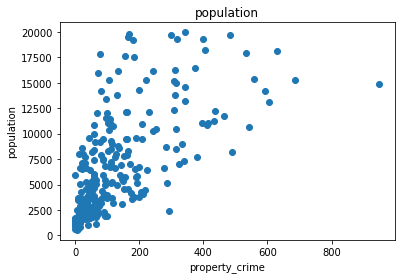

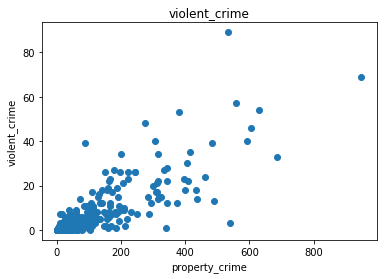

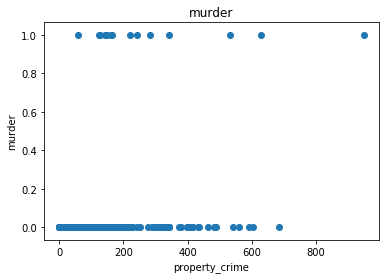

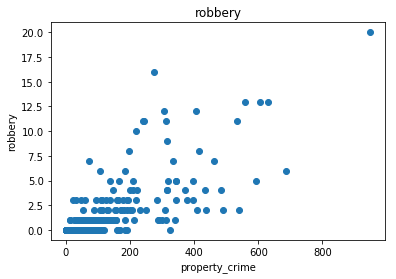

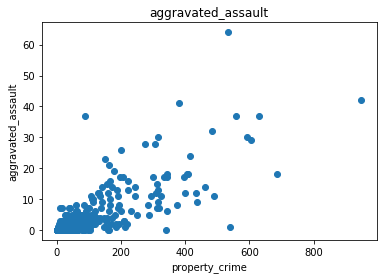

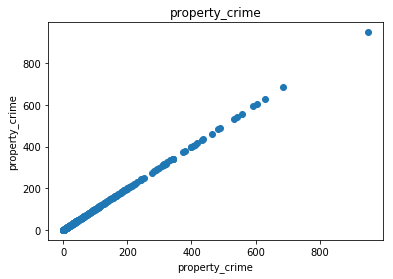

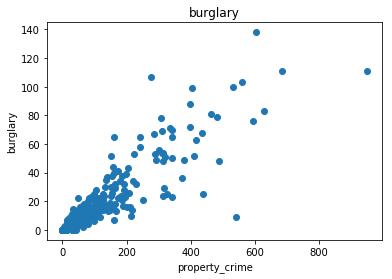

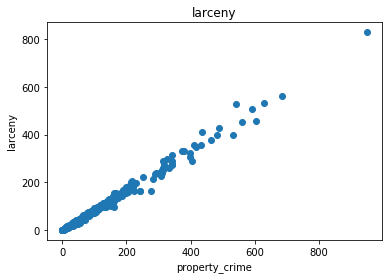

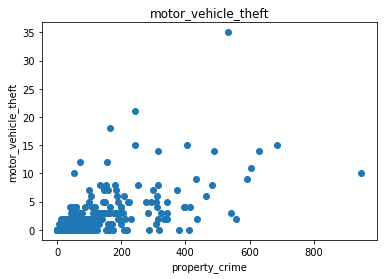

In [74]:
for crime in list(df_crime.columns[1:10]):
    plt.scatter(restricted_crime.property_crime, 
                restricted_crime[crime])
    plt.title(crime)
    plt.xlabel('property_crime')
    plt.ylabel(crime)
    plt.show()

In [77]:
#Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = restricted_crime['property_crime']
X = restricted_crime[['population', 'population_squared', 'robbery', 'burglary', 'larceny']]
regr.fit(X,Y)

# Results

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
print(pd.DataFrame(data={'variables':X.columns,'coef':regr.coef_}))


Coefficients: 
 [-1.19874585e-04  1.68865240e-08  3.36754947e-01  1.02675091e+00
  1.00290166e+00]

Intercept: 
 0.7477781655370137

R-squared:
0.999564794540339
            variables   coef
0          population -0.000
1  population_squared  0.000
2             robbery  0.337
3            burglary  1.027
4             larceny  1.003


In [78]:
#Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = restricted_crime['property_crime']
X = restricted_crime[['population', 'population_squared', 'murder', 'robbery_flag']]
regr.fit(X,Y)

# Results

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
print(pd.DataFrame(data={'variables':X.columns,'coef':regr.coef_}))


Coefficients: 
 [1.30922586e-02 6.74851600e-08 6.93408391e+01 8.95669127e+01]

Intercept: 
 -12.22774855938411

R-squared:
0.5376768928235551
            variables   coef
0          population  0.013
1  population_squared  0.000
2              murder 69.341
3        robbery_flag 89.567


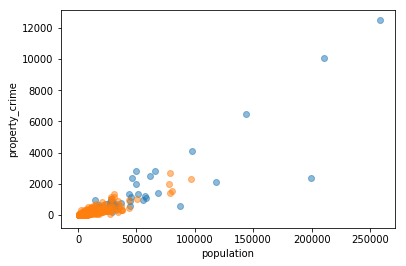

In [69]:
plt.scatter(x=crime_restricted[crime_restricted['murder']==1].population, 
            y=crime_restricted[crime_restricted['murder']==1].property_crime, alpha=0.5)
plt.scatter(x=crime_restricted[crime_restricted['murder']==0].population, 
            y=crime_restricted[crime_restricted['murder']==0].property_crime, alpha=0.5)
plt.xlabel('population')
plt.ylabel('property_crime')
plt.show()

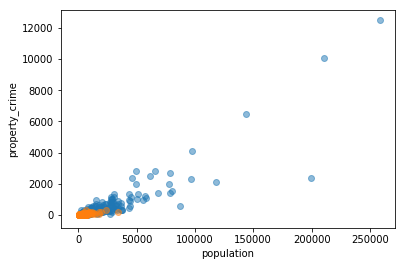

In [68]:
plt.scatter(x=crime_restricted[crime_restricted['robbery']==1].population, 
            y=crime_restricted[crime_restricted['robbery']==1].property_crime, alpha=0.5)
plt.scatter(x=crime_restricted[crime_restricted['robbery']==0].population, 
            y=crime_restricted[crime_restricted['robbery']==0].property_crime, alpha=0.5)
plt.xlabel('population')
plt.ylabel('property_crime')
plt.show()

(0, 20000)

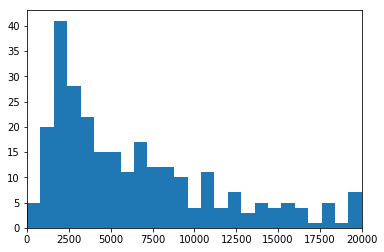

In [23]:
plt.hist(df_crime['population'], 
         bins=25, 
         range=(0,20000))
plt.xlim(0,20000)

{'whiskers': [<matplotlib.lines.Line2D at 0xa1be1e2e8>,
 'caps': [<matplotlib.lines.Line2D at 0xa1be1eba8>,
 'boxes': [<matplotlib.lines.Line2D at 0xa1be1e198>],
 'medians': [<matplotlib.lines.Line2D at 0xa1be28438>],
 'fliers': [<matplotlib.lines.Line2D at 0xa1be28860>],
 'means': []}

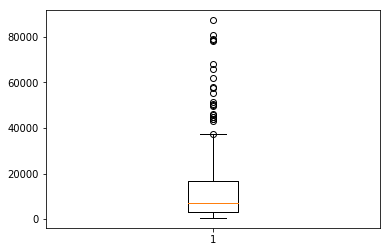

In [31]:
plt.boxplot(df_crime[df_crime['population']<90000]['population'])

In [15]:
df_crime.describe().loc['25%','population']
df_crime.describe().loc['25%','population']
df_crime.describe().loc['25%','population']

3003.0

In [95]:
crime_subset.population.describe()

count    3.480000e+02
mean     4.003763e+04
std      4.500374e+05
min      5.260000e+02
25%      3.003000e+03
50%      7.233500e+03
75%      1.842750e+04
max      8.396126e+06
Name: population, dtype: float64

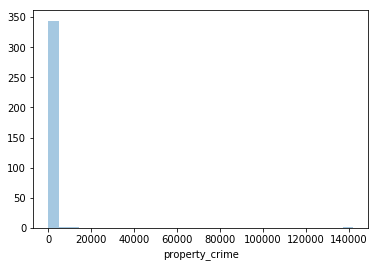

In [56]:
sns.distplot(crime_subset.property_crime, bins=30, kde=False)

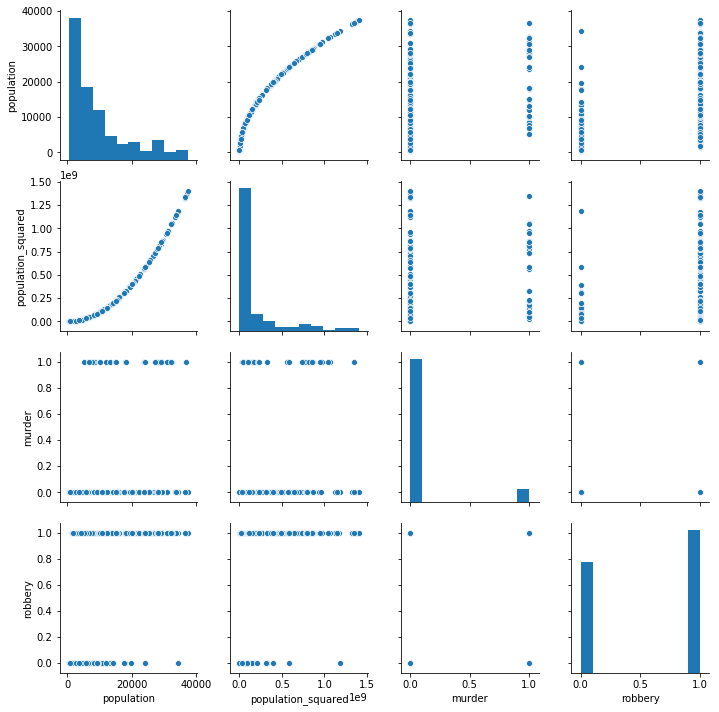

In [34]:
import seaborn as sns
sns.pairplot(data=crime_subset[crime_subset['population']<40000])

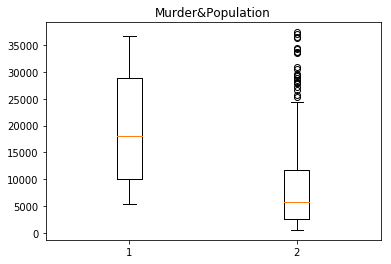

In [46]:
fig, ax = plt.subplots()
murder = [crime_subset[(crime_subset['population']<40000)&(crime_subset['murder']==1)]['population'],crime_subset[(crime_subset['population']<40000)&(crime_subset['murder']==0)]['population']]
plt.title('Murder&Population')
ax.set_xticklabels(labels=['murder', 'no murder'])
ax.boxplot(murder)
plt.show()

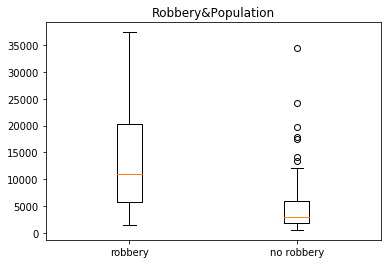

In [50]:
fix, ax = plt.subplots()
robbery = [crime_subset[(crime_subset['population']<40000)&(crime_subset['robbery']==1)]['population'],
        crime_subset[(crime_subset['population']<40000)&(crime_subset['robbery']==0)]['population']]
plt.title('Robbery&Population')
ax.boxplot(robbery)
ax.set_xticklabels(labels=['robbery', 'no robbery'])
plt.show()